## Step #1 Prototype Analysis

Firstly we are going to extract the partial content of the images to use them to extract features form the two first rows and the header, this in order to have a sample of what two continous rows look together and differntiate it from what for example a header may look like

1. Row Structure Detection

- Detect horizontal lines/separators using Hough Line Transform
- Calculate average row height from the 2 sample rows
- Identify row spacing patterns (padding, borders)


2. Column Sructure Detection

- Detect vertical separators (lines or whitespace boundaries)
- Use contour detection on text regions to find column alignment
- Calculate column widths and spacing


Header Characteristics

- Text properties (font size, weight, color)
- Background differentiation (SAP has gray header, WEB has white)
- Alignment patterns





In [2]:
import numpy as np
import cv2
from typing import List, Optional, Tuple
from dataclasses import dataclass # Facilitates the creation of classes avoiding some usual methods like __init__
import matplotlib.pyplot as plt
from enum import Enum
%matplotlib inline

plt.rcParams['image.cmap'] = 'gray' # Make the default color mapping to gray


The shape of SAP is (1080, 1920, 3) and the type of the data is uint8 
The shape of WEB is (1599, 2399, 3) and the type of the data is uint8 


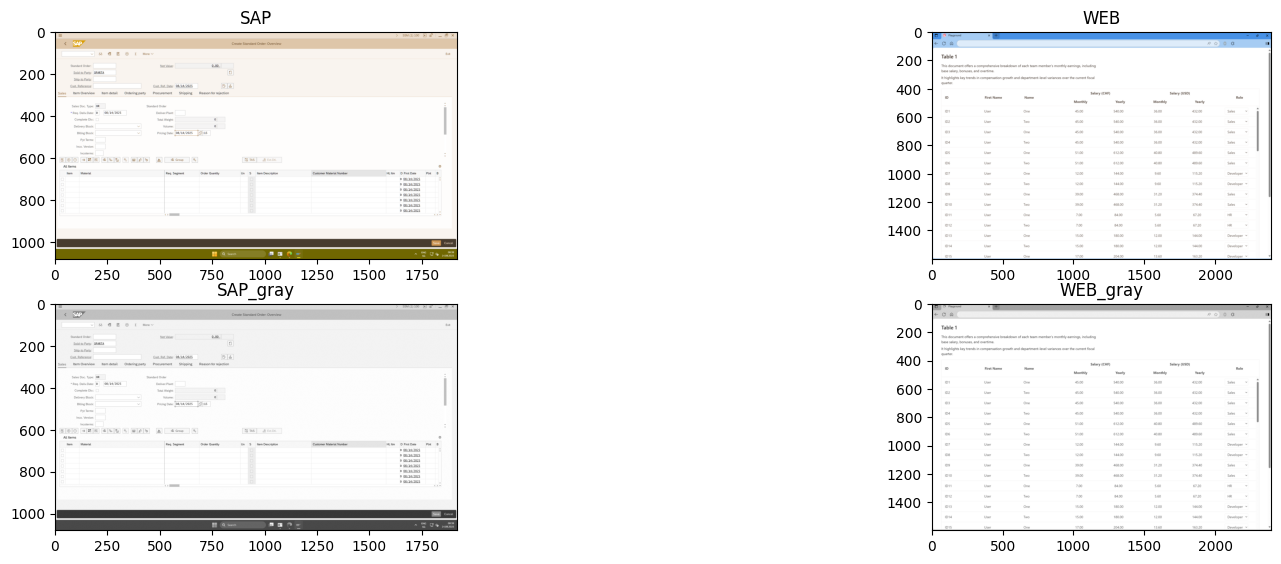

In [5]:
SAP_imagepath = "media/SAP.png"
WEB_imagepath = "media/WEB.png"

SAP = cv2.imread(SAP_imagepath)
WEB = cv2.imread(WEB_imagepath)

# Know the size
print(f"The shape of SAP is {SAP.shape} and the type of the data is {SAP.dtype} ")
print(f"The shape of WEB is {WEB.shape} and the type of the data is {WEB.dtype} ")



SAP_gray = cv2.cvtColor(SAP, cv2.COLOR_BGR2GRAY)
WEB_gray = cv2.cvtColor(WEB, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(20,10))
plt.subplot(3,2,1) ; plt.imshow(SAP) ; plt.title('SAP')
plt.subplot(3,2,2) ; plt.imshow(WEB)  ; plt.title('WEB')
plt.subplot(3,2,3) ; plt.imshow(SAP_gray) ; plt.title('SAP_gray')
plt.subplot(3,2,4) ; plt.imshow(WEB_gray) ; plt.title('WEB_gray')
plt.show()

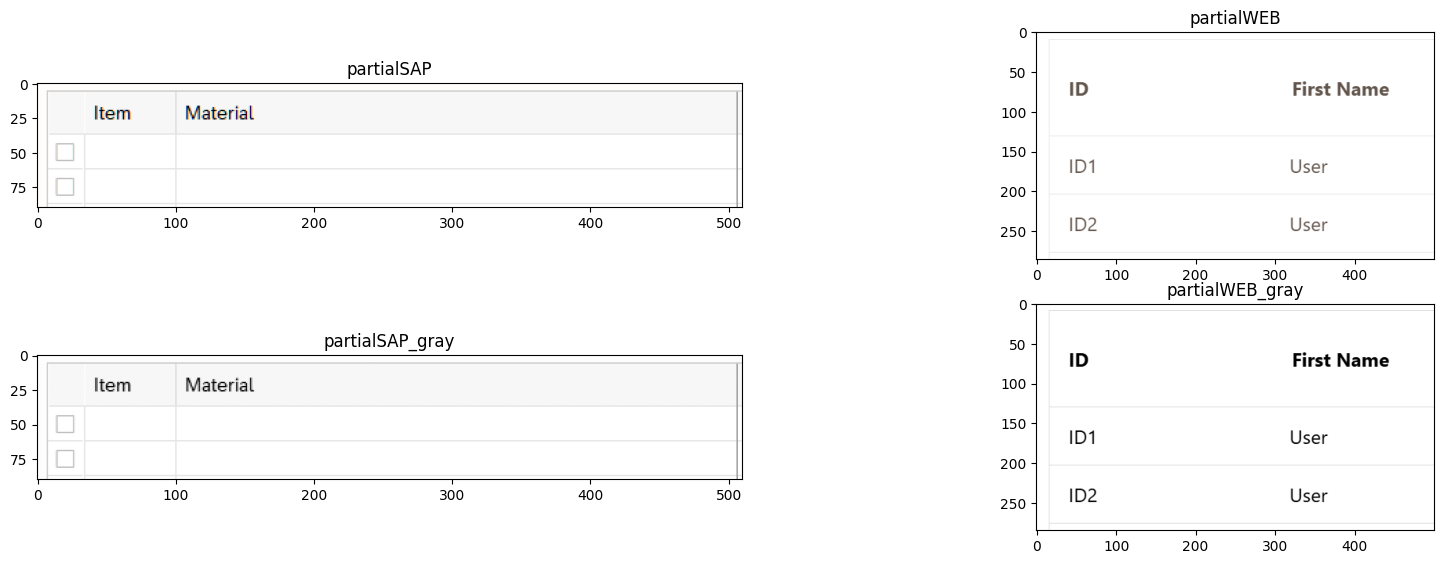

partial_color_SAP.shape (90, 510, 3)
partial_color_WEB.shape (285, 500, 3)


In [9]:
partial_color_SAP = SAP[650: 740,15 :525 , :]
partial_color_WEB = WEB[390 :675 ,50 :  550, : ]

partial_gray_SAP = SAP_gray[650: 740,15 :525 ]
partial_gray_WEB = WEB_gray[390 :675 ,50 :  550]

#Record the Output of the partial_Gray to use it in the Computer Vision
cv2.imwrite("./media/partial_gray_SAP.png", partial_gray_SAP)
cv2.imwrite("./media/partial_gray_WEB.png", partial_gray_WEB)

plt.figure(figsize=(20,10))
plt.subplot(3,2,1) ; plt.imshow(partial_color_SAP) ; plt.title('partialSAP')
plt.subplot(3,2,2) ; plt.imshow(partial_color_WEB)  ; plt.title('partialWEB')
plt.subplot(3,2,3) ; plt.imshow(partial_gray_SAP) ; plt.title('partialSAP_gray')
plt.subplot(3,2,4) ; plt.imshow(partial_gray_WEB) ; plt.title('partialWEB_gray')
plt.show()

# Show aproximation of the size of the sapce that the rows occupy

print("partial_color_SAP.shape" , partial_color_SAP.shape)
print("partial_color_WEB.shape" , partial_color_WEB.shape)



In this section we are going to store some of the expected answers from the model in the instruction PDF for example

- Identify a table on the screen based on the given image that shows a partial image
- Return the boundaries of the table
- Identify the Headers boundaries of the table
- Row and Columnd boundaries withing the table
- Cell Boundaries


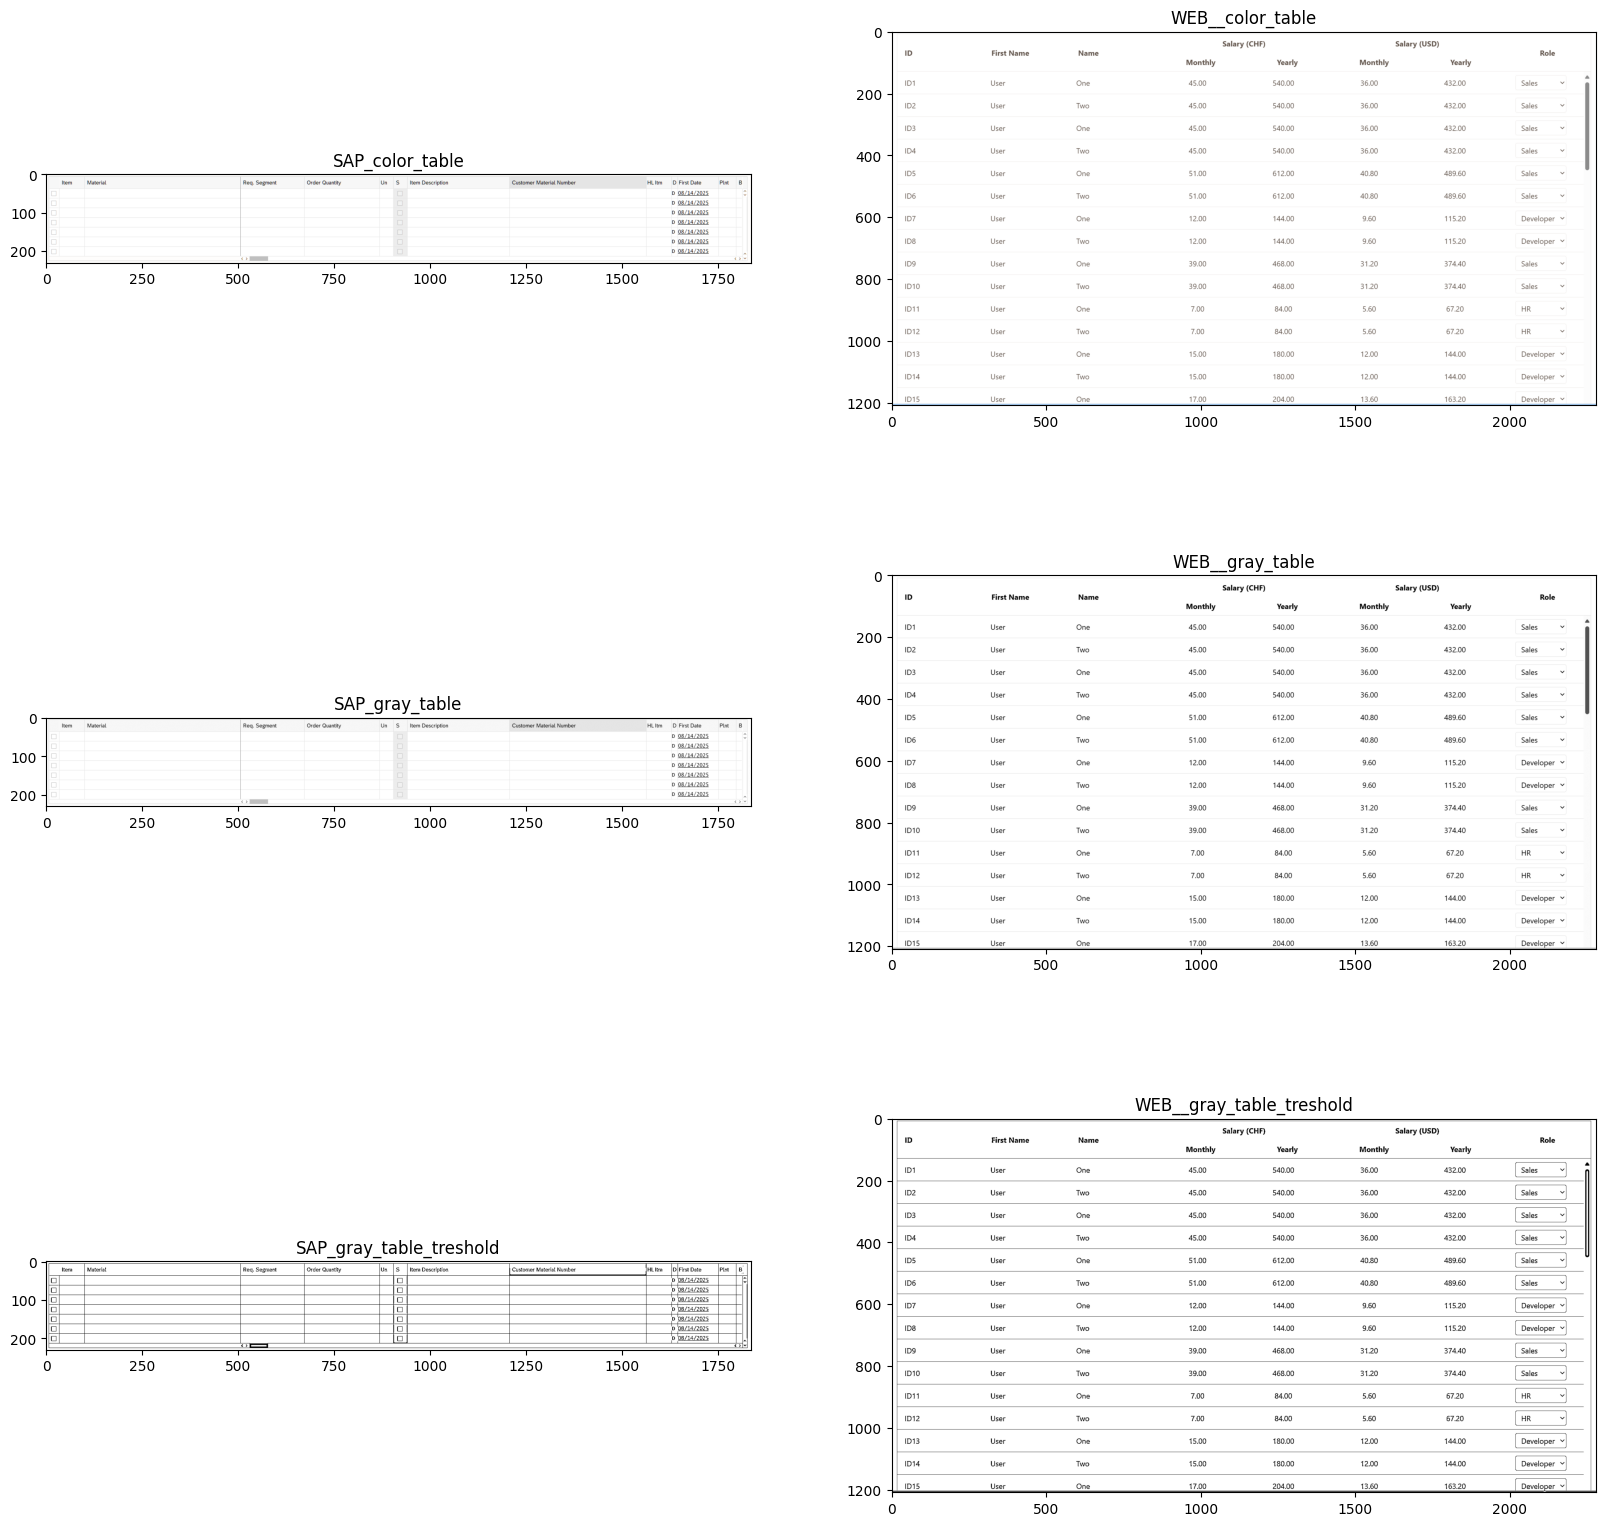

In [7]:
# 1 The tables
SAP_color_table = SAP[650: 880,15 :1850 , :]
WEB__color_table = WEB[390 :1599 ,50 :  2330, : ]

SAP_gray_table = SAP_gray[650: 880,15 :1850 ]
WEB__gray_table = WEB_gray[390 :1599 ,50 :  2330]


SAP_gray_table_treshold = cv2.adaptiveThreshold( SAP_gray_table, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
WEB__gray_table_treshold = cv2.adaptiveThreshold( WEB__gray_table, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 2 Boundaries

SAP_color_table_boundaries = {
    "ROW" : (650, 880),
    "COLUMN" : (15, 1850)
}

WEB__color_table_Boundaries = {
    "ROW" : (390, 1599),
    "COLUMN" : (50, 2330)
}




plt.figure(figsize=(20,20))
plt.subplot(3,2,1) ; plt.imshow(SAP_color_table) ; plt.title('SAP_color_table')
plt.subplot(3,2,2) ; plt.imshow(WEB__color_table)  ; plt.title('WEB__color_table')
plt.subplot(3,2,3) ; plt.imshow(SAP_gray_table) ; plt.title('SAP_gray_table')
plt.subplot(3,2,4) ; plt.imshow(WEB__gray_table) ; plt.title('WEB__gray_table')
plt.subplot(3,2,5) ; plt.imshow(SAP_gray_table_treshold) ; plt.title('SAP_gray_table_treshold')
plt.subplot(3,2,6) ; plt.imshow(WEB__gray_table_treshold) ; plt.title('WEB__gray_table_treshold')
plt.show()

# 3


# Cordinates of the rows based on the lines
SAP_horizontal_lines = [] # Cordinates in the y-axis for the table lines
WEB__horizontal_lines = [] # Cordinates in the y-axis for the table lines

# Cordinates of the columns based on the lines
SAP_vertical_lines = [] # Cordinates in the x-axis for the table lines
WEB__vertical_lines = [] # Cordinates in the x-axis for the table lines

# Aproximations
SAP_average_row_height = 0
WEB__average_row_height = 0

SAP_average_column_width = 0
WEB_average_column_width = 0



# 4

# 5




### Phase #2 Full table detection

Note that SAP has strong row / column separaors that will make the task easier, but on the other hand WEB does not has this intuitive approach to identify the table by scanning for rows and colums, for this we would use slighly different approaches on each one

For SAP (Strong Visual Separators):

- Apply adaptive thresholding to detect grid lines
- Use cv2.HoughLinesP() for line detection
- Filter lines by orientation (horizontal vs vertical) and spacing patterns - learned from prototype
- Reconstruct grid structure

For WEB (Minimal Visual Separators):

- Text-based approach using OCR or text detection
- Apply morphological operations to connect text regions within rows
- Use whitespace analysis to detect column boundaries
- Leverage consistent alignment patterns

In this section we are going to store some of the expected answers from the model in the instruction PDF for example

- Identify a table on the screen based on the given image that shows a partial image
- Return the boundaries of the table
- Identify the Headers boundaries of the table
- Row and Columnd boundaries withing the table
- Cell Boundaries


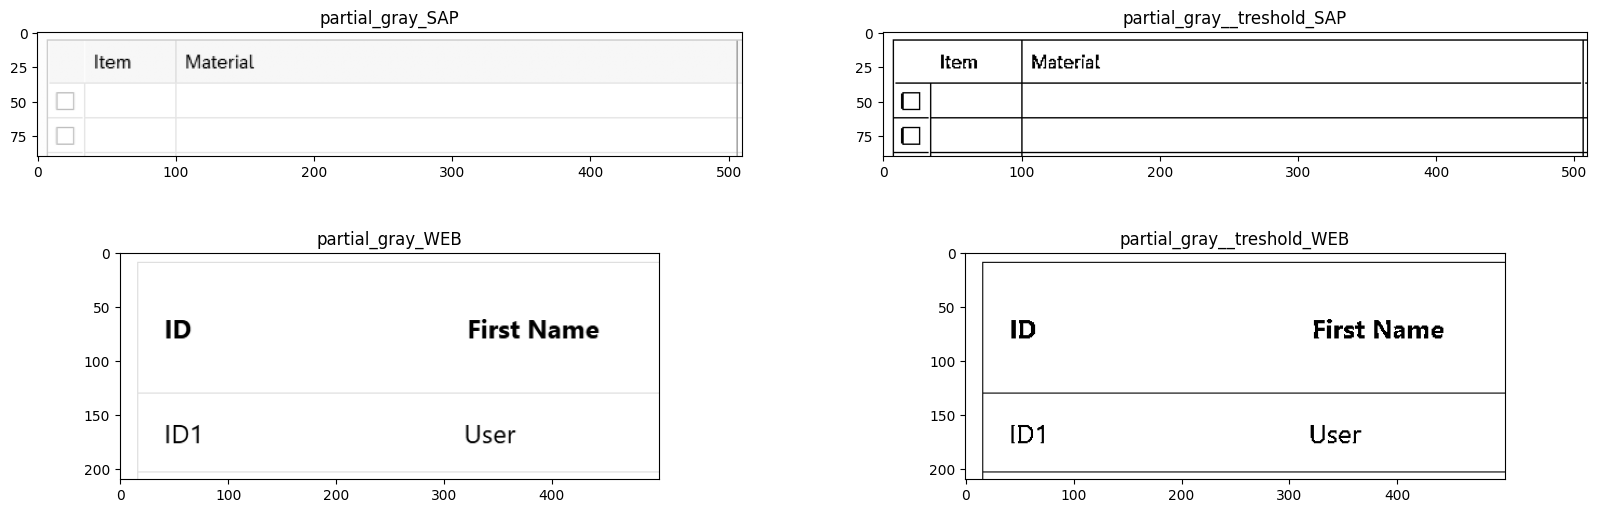

In [ ]:
partial_gray__treshold_SAP = cv2.adaptiveThreshold( partial_gray_SAP, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
partial_gray__treshold_WEB = cv2.adaptiveThreshold( partial_gray_WEB, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


plt.figure(figsize=(20,10))
plt.subplot(3,2,1) ; plt.imshow(partial_gray_SAP) ; plt.title('partial_gray_SAP')
plt.subplot(3,2,2) ; plt.imshow(partial_gray__treshold_SAP)  ; plt.title('partial_gray__treshold_SAP')
plt.subplot(3,2,3) ; plt.imshow(partial_gray_WEB) ; plt.title('partial_gray_WEB')
plt.subplot(3,2,4) ; plt.imshow(partial_gray__treshold_WEB) ; plt.title('partial_gray__treshold_WEB')

plt.show()




In [9]:
class TableType(Enum):
    SAP = "SAP"
    WEB = "WEB"
    UNKNOWN = "UNKNOWN"

@dataclass
class LineFeatures:
    """Extracted structural features from table lines"""
    horizontal_positions: List[int]  # Y-coordinates of horizontal lines
    vertical_positions: List[int]    # X-coordinates of vertical lines
    average_row_height: float
    average_column_width: float
    header_height: int

    def __repr__(self):
        return (f"LineFeatures(rows={len(self.horizontal_positions)}, "
                f"cols={len(self.vertical_positions)}, "
                f"avg_row_h={self.average_row_height:.1f}, "
                f"avg_col_w={self.average_column_width:.1f})")

class TablePrototype:
    """A table prototype with extracting capabilities"""

    def __init__(self, image: np.ndarray, name: str = ""):
        self.original_image = image
        self.name = name
        self.gray_image = None
        self.threshold_image = None
        self.line_features: Optional[LineFeatures] = None
        self.table_type: TableType = TableType.UNKNOWN
        self.boundaries = None  # (y_min, y_max, x_min, x_max)

    def preprocess(self) -> np.ndarray:
        """Convert to grayscale and apply adaptive thresholding"""
        # Grayscale conversion
        if len(self.original_image.shape) == 3: # It is RGB
            self.gray_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)
        else:
            self.gray_image = self.original_image.copy()

        # Adaptive thresholding
        self.threshold_image = cv2.adaptiveThreshold(
            self.gray_image,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blockSize=11,
            C=2
        )

        # Invert for white lines on black background
        self.threshold_image = cv2.bitwise_not(self.threshold_image)

        return self.threshold_image

    def extract_line_features(self) -> LineFeatures:
        """Automatically extract line features from the table"""
        if self.threshold_image is None:
            self.preprocess()

        # Morphological operations to detect lines
        h_lines, v_lines = self._detect_lines_morphology()

        # Get line positions using projection
        h_positions = self._detect_horizontal_projections(h_lines)
        v_positions = self._detect_vertical_projections(v_lines)

        # If few lines detected, try text-based approach (for WEB)
        if len(h_positions) < 3:
            h_positions, v_positions = self._detect_text_based_structure()
            self.table_type = TableType.WEB
        else:
            self.table_type = TableType.SAP

        # Calculate statistics
        avg_row_height = self._calculate_average_spacing(h_positions)
        avg_col_width = self._calculate_average_spacing(v_positions)
        header_height = h_positions[1] - h_positions[0] if len(h_positions) >= 2 else 0

        self.line_features = LineFeatures(
            horizontal_positions=h_positions,
            vertical_positions=v_positions,
            average_row_height=avg_row_height,
            average_column_width=avg_col_width,
            header_height=header_height
        )

        return self.line_features

    def _detect_lines_morphology(self) -> Tuple[np.ndarray, np.ndarray]:
        """Detect horizontal and vertical lines using morphological operations"""
        height, width = self.threshold_image.shape

        # Horizontal lines: wide horizontal kernel
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width // 4, 1))
        horizontal_lines = cv2.morphologyEx(self.threshold_image, cv2.MORPH_OPEN, h_kernel)

        # Vertical lines: tall vertical kernel
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, height // 4))
        vertical_lines = cv2.morphologyEx(self.threshold_image, cv2.MORPH_OPEN, v_kernel)

        return horizontal_lines, vertical_lines

    def _detect_horizontal_projections(self, line_image: np.ndarray) -> List[int]:
        """Detect horizontal line positions using vertical projection"""
        positions = []
        height = line_image.shape[0]

        # Sum pixel values along each row
        for y in range(height):
            row_sum = np.sum(line_image[y, :])
            # If row sum exceeds threshold, it's likely a line
            threshold = line_image.shape[1] * 255 * 0.3  # 30% white pixels
            if row_sum > threshold:
                positions.append(y)

        # Merge similar positions (remove duplicates from thick lines)
        return self._merge_similar_positions(positions, threshold=5)

    def _detect_vertical_projections(self, line_image: np.ndarray) -> List[int]:
        """Detect vertical line positions using horizontal projection"""
        positions = []
        width = line_image.shape[1]

        # Sum pixel values along each column
        for x in range(width):
            col_sum = np.sum(line_image[:, x])
            threshold = line_image.shape[0] * 255 * 0.3
            if col_sum > threshold:
                positions.append(x)

        return self._merge_similar_positions(positions, threshold=5)

    def _merge_similar_positions(self, positions: List[int], threshold: int) -> List[int]:
        """Merge positions that are too close together"""
        if not positions:
            return []

        positions = sorted(positions)
        merged = [positions[0]]

        for pos in positions[1:]:
            if pos - merged[-1] > threshold:
                merged.append(pos)

        return merged

    def _calculate_average_spacing(self, positions: List[int]) -> float:
        """Calculate average spacing between consecutive positions"""
        if len(positions) < 2:
            return 0.0

        spacings = [positions[i+1] - positions[i] for i in range(len(positions)-1)]
        return np.mean(spacings)

    def _detect_text_based_structure(self) -> Tuple[List[int], List[int]]:
        """Alternative approach for tables with minimal visual separators (WEB)"""
        # Apply binary threshold
        _, binary = cv2.threshold(self.gray_image, 0, 255,
                                  cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours (text regions)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Get bounding boxes
        text_boxes = [cv2.boundingRect(c) for c in contours]
        text_boxes = [(x, y, w, h) for x, y, w, h in text_boxes
                      if w > 10 and h > 5]  # Filter noise

        # Group by Y-coordinate to find rows
        y_coords = [y for _, y, _, _ in text_boxes]
        h_positions = self._cluster_coordinates(y_coords, tolerance=10)

        # Group by X-coordinate to find columns
        x_coords = [x for x, _, _, _ in text_boxes]
        v_positions = self._cluster_coordinates(x_coords, tolerance=20)

        return h_positions, v_positions

    def _cluster_coordinates(self, coords: List[int], tolerance: int) -> List[int]:
        """Cluster coordinates within tolerance"""
        if not coords:
            return []

        coords = sorted(coords)
        clusters = [[coords[0]]]

        for coord in coords[1:]:
            if coord - clusters[-1][-1] <= tolerance:
                clusters[-1].append(coord)
            else:
                clusters.append([coord])

        # Return centroid of each cluster
        return [int(np.mean(cluster)) for cluster in clusters]

    def calculate_table_boundaries(self):
        """Calculate table boundaries in required format"""
        if not self.line_features or not self.line_features.horizontal_positions or not self.line_features.vertical_positions:
            return {}
        
        min_x = min(self.line_features.vertical_positions) if self.line_features.vertical_positions else 0
        max_x = max(self.line_features.vertical_positions) if self.line_features.vertical_positions else self.original_image.shape[1]
        min_y = min(self.line_features.horizontal_positions) if self.line_features.horizontal_positions else 0
        max_y = max(self.line_features.horizontal_positions) if self.line_features.horizontal_positions else self.original_image.shape[0]
        
        return {
            "topleft": (min_x, min_y),
            "topright": (max_x, min_y),
            "bottomleft": (min_x, max_y),
            "bottomright": (max_x, max_y)
        }
    
    def calculate_header_boundaries(self):
        """Calculate header boundaries in required format"""
        if not self.line_features or not self.line_features.horizontal_positions or len(self.line_features.horizontal_positions) < 2:
            return {}
        
        min_x = min(self.line_features.vertical_positions) if self.line_features.vertical_positions else 0
        max_x = max(self.line_features.vertical_positions) if self.line_features.vertical_positions else self.original_image.shape[1]
        header_top = self.line_features.horizontal_positions[0]
        header_bottom = self.line_features.horizontal_positions[1]
        
        return {
            "topleft": (min_x, header_top),
            "topright": (max_x, header_top),
            "bottomleft": (min_x, header_bottom),
            "bottomright": (max_x, header_bottom)
        }

    def visualize_features(self, save_path: Optional[str] = None) -> np.ndarray:
        """Visualize detected features on the image with specific color coding"""
        if self.line_features is None:
            self.extract_line_features()

        # Create visualization
        vis_image = self.original_image.copy()
        if len(vis_image.shape) == 2:
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)

        # a. Complete table in red (rectangle)
        table_bounds = self.calculate_table_boundaries()
        if table_bounds:
            cv2.rectangle(vis_image, table_bounds["topleft"], table_bounds["bottomright"], (0, 0, 255), 3)

        # b. Header in green (rectangle)
        header_bounds = self.calculate_header_boundaries()
        if header_bounds:
            cv2.rectangle(vis_image, header_bounds["topleft"], header_bounds["bottomright"], (0, 255, 0), 3)

        # c. Rows in yellow (rectangle)
        if self.line_features and len(self.line_features.horizontal_positions) > 1:
            min_x = min(self.line_features.vertical_positions) if self.line_features.vertical_positions else 0
            max_x = max(self.line_features.vertical_positions) if self.line_features.vertical_positions else vis_image.shape[1]
            
            for i in range(1, len(self.line_features.horizontal_positions) - 1):
                row_top = self.line_features.horizontal_positions[i]
                row_bottom = self.line_features.horizontal_positions[i + 1]
                cv2.rectangle(vis_image, (min_x, row_top), (max_x, row_bottom), (0, 255, 255), 2)

        # d. Columns with straight strokes in black
        if self.line_features:
            for x in self.line_features.vertical_positions:
                cv2.line(vis_image, (x, 0), (x, vis_image.shape[0]), (0, 0, 0), 2)

        # Add text annotation
        text = (f"{self.name} | Type: {self.table_type.value} | "
                f"Rows: {len(self.line_features.horizontal_positions)} | "
                f"Cols: {len(self.line_features.vertical_positions)}")
        cv2.putText(vis_image, text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        if save_path:
            cv2.imwrite(save_path, vis_image)

        return vis_image

    def get_summary(self) -> dict:
        """Get summary statistics of the table including boundaries"""
        if self.line_features is None:
            self.extract_line_features()

        table_boundaries = self.calculate_table_boundaries()
        header_boundaries = self.calculate_header_boundaries()

        return {
            "name": self.name,
            "type": self.table_type.value,
            "dimensions": self.original_image.shape,
            "num_rows": len(self.line_features.horizontal_positions),
            "num_cols": len(self.line_features.vertical_positions),
            "avg_row_height": self.line_features.average_row_height,
            "avg_col_width": self.line_features.average_column_width,
            "header_height": self.line_features.header_height,
            "table_boundaries": table_boundaries,
            "header_boundaries": header_boundaries
        }

LineFeatures(rows=10, cols=14, avg_row_h=24.2, avg_col_w=139.8)
LineFeatures(rows=17, cols=2, avg_row_h=74.8, avg_col_w=2244.0)

=== SAP Analysis ===
Boundaries of the complete table in the screenshot:
  topleft: (7, 6)
  topright: (1824, 6)
  bottomleft: (7, 224)
  bottomright: (1824, 224)
Boundaries of header:
  topleft: (7, 6)
  topright: (1824, 6)
  bottomleft: (7, 37)
  bottomright: (1824, 37)

=== WEB Analysis ===
Boundaries of the complete table in the screenshot:
  topleft: (16, 9)
  topright: (2260, 9)
  bottomleft: (16, 1205)
  bottomright: (2260, 1205)
Boundaries of header:
  topleft: (16, 9)
  topright: (2260, 9)
  bottomleft: (16, 130)
  bottomright: (2260, 130)

SAP Summary:
  name: SAP
  type: SAP
  dimensions: (230, 1835, 3)
  num_rows: 10
  num_cols: 14
  avg_row_height: 24.22222222222222
  avg_col_width: 139.76923076923077
  header_height: 31

WEB Summary:
  name: WEB
  type: SAP
  dimensions: (1209, 2280, 3)
  num_rows: 17
  num_cols: 2
  avg_row_height: 74.75
  avg_

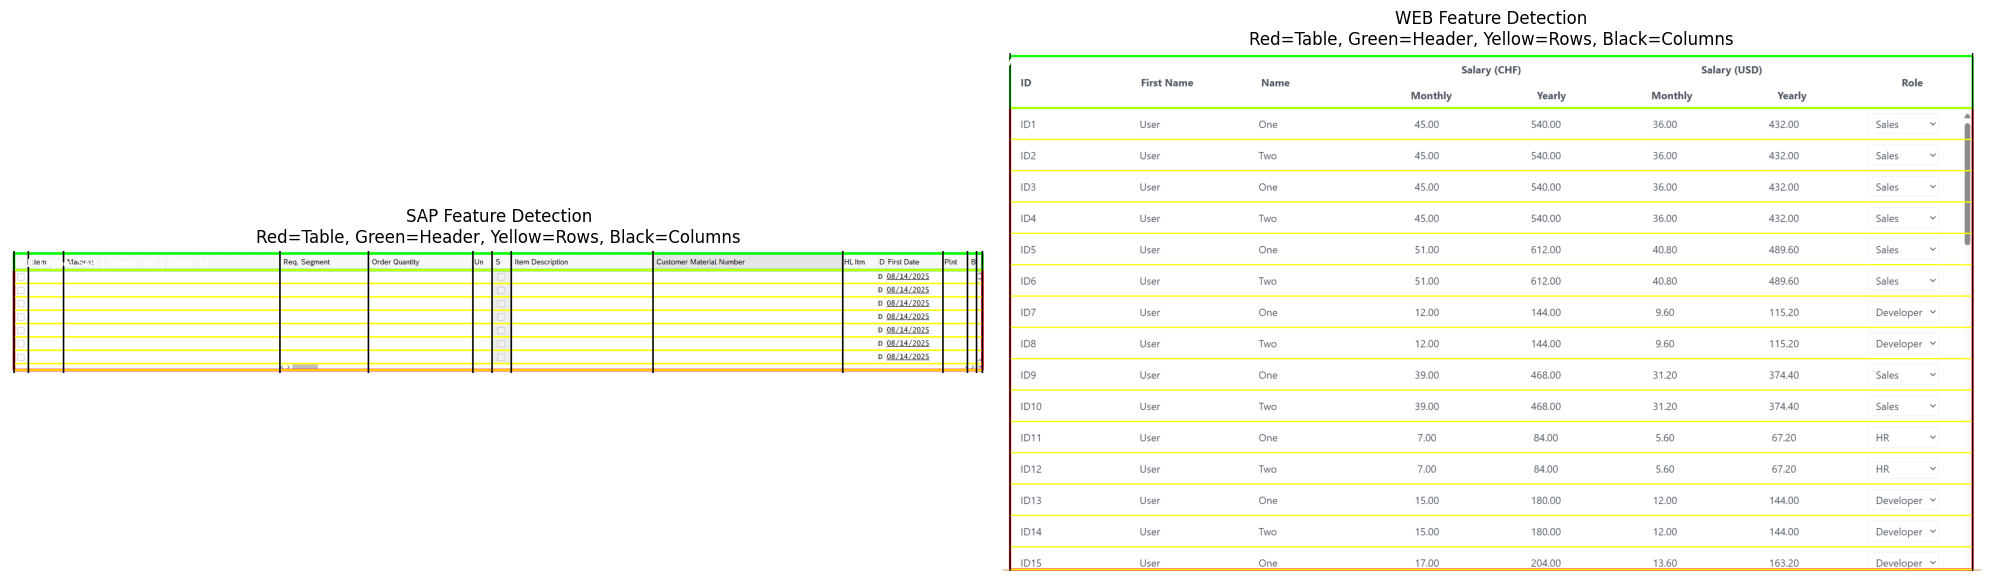

In [ ]:
# Usage
# Create table prototypes
sap_table = TablePrototype(SAP_color_table, name="SAP")
web_table = TablePrototype(WEB__color_table, name="WEB")

# Extract features automatically
sap_features = sap_table.extract_line_features()
web_features = web_table.extract_line_features()

# Print results
print(sap_features)
print(web_features)

def print_boundaries(table_prototype, table_name):
    """Print boundaries in the required format"""
    summary = table_prototype.get_summary()
    
    print(f"\n=== {table_name} Analysis ===")
    
    # 1. StdOut: Boundaries of the complete table in the screenshot
    if "table_boundaries" in summary and summary["table_boundaries"]:
        table_bounds = summary["table_boundaries"]
        print("Boundaries of the complete table in the screenshot:")
        print(f"  topleft: {table_bounds['topleft']}")
        print(f"  topright: {table_bounds['topright']}")
        print(f"  bottomleft: {table_bounds['bottomleft']}")
        print(f"  bottomright: {table_bounds['bottomright']}")
    
    # 2. StdOut: Boundaries of header
    if "header_boundaries" in summary and summary["header_boundaries"]:
        header_bounds = summary["header_boundaries"]
        print("Boundaries of header:")
        print(f"  topleft: {header_bounds['topleft']}")
        print(f"  topright: {header_bounds['topright']}")
        print(f"  bottomleft: {header_bounds['bottomleft']}")
        print(f"  bottomright: {header_bounds['bottomright']}")

# Print boundaries for both tables
print_boundaries(sap_table, "SAP")
print_boundaries(web_table, "WEB")

print("\n" + "="*50)
print("SAP Summary:")
sap_summary = sap_table.get_summary()
for key, value in sap_summary.items():
    if key not in ["table_boundaries", "header_boundaries"]:
        print(f"  {key}: {value}")

print("\n" + "="*50)
print("WEB Summary:")
web_summary = web_table.get_summary()
for key, value in web_summary.items():
    if key not in ["table_boundaries", "header_boundaries"]:
        print(f"  {key}: {value}")

# 3. Visualize with color coding
# a. Complete table in red (rectangle)
# b. Header in green (rectangle)  
# c. Rows in yellow (rectangle)
# d. Columns with straight strokes in black
sap_vis = sap_table.visualize_features(save_path="sap_features.png")
web_vis = web_table.visualize_features(save_path="web_features.png")

# Display
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sap_vis, cv2.COLOR_BGR2RGB))
plt.title('SAP Feature Detection\nRed=Table, Green=Header, Yellow=Rows, Black=Columns')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(web_vis, cv2.COLOR_BGR2RGB))
plt.title('WEB Feature Detection\nRed=Table, Green=Header, Yellow=Rows, Black=Columns')
plt.axis('off')

plt.tight_layout()
plt.show()